<a href="https://colab.research.google.com/github/king-nourou/Projet-ANDO/blob/main/CCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn pour la préparation, la réduction de dimension et le clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Prince pour l'Analyse des Correspondances Multiples (ACM)
!pip install prince
import prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 7.6 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('Airbnb_NYC_2019.csv')

In [3]:
# 1. Gestion des valeurs manquantes
# reviews_per_month : si NaN, c'est qu'il n'y a pas de reviews. On remplace par 0.
df['reviews_per_month'].fillna(0, inplace=True)
print(f"Valeurs manquantes dans 'reviews_per_month' remplacées par 0.")

# On supprime les colonnes qui ne seront pas utiles pour cette analyse
df.drop(['name', 'host_name', 'last_review'], axis=1, inplace=True)
print("Colonnes inutiles ('name', 'host_name', 'last_review') supprimées.")

# 2. Gestion des outliers et erreurs de données
# On observe que certains prix sont à 0, ce qui est une erreur. On les supprime.
df = df[df['price'] > 0]

# Les prix très élevés peuvent fausser l'analyse. On se concentre sur les 99% des offres les moins chères.
price_cap = df['price'].quantile(0.99)
df = df[df['price'] < price_cap]
print(f"Annonces avec un prix de 0 supprimées. Outliers de prix (> {price_cap}$) filtrés.")
print(f"Nouvelle taille du dataset : {df.shape[0]} lignes.")

# 3. Feature Engineering
# Création d'une variable "log_price" pour normaliser la distribution du prix
df['log_price'] = np.log1p(df['price'])
print("Variable 'log_price' créée pour une meilleure distribution.")

# On ne garde que les colonnes utiles pour la suite
df_clean = df[['id', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price', 'log_price',
               'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
               'availability_365']].copy()

Valeurs manquantes dans 'reviews_per_month' remplacées par 0.
Colonnes inutiles ('name', 'host_name', 'last_review') supprimées.
Annonces avec un prix de 0 supprimées. Outliers de prix (> 799.0$) filtrés.
Nouvelle taille du dataset : 48392 lignes.
Variable 'log_price' créée pour une meilleure distribution.


/tmp/ipython-input-2486283260.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)


In [5]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA

# Définition des groupes
X = df[['calculated_host_listings_count', 'availability_365', 'minimum_nights']]
Y = df[['log_price', 'number_of_reviews', 'reviews_per_month']]

# SCALING
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y)

# Exécution de la CCA
cca = CCA(n_components=2)
cca.fit(X_scaled, Y_scaled)
X_c, Y_c = cca.transform(X_scaled, Y_scaled)

# 1. Calcul des corrélations canoniques (Elles mesurent la force de la relation)
# On calcule la corrélation entre la première composante de X et la première de Y, etc.
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]

# 2. Calcul des Loadings (Poids) - Pour l'interprétation des axes
# Ces valeurs montrent la corrélation entre les variables originales et les nouvelles composantes.
x_loadings = np.corrcoef(X_scaled.T, X_c.T)[:3, 3:]
y_loadings = np.corrcoef(Y_scaled.T, Y_c.T)[:3, 3:]

# 3. AFFICHAGE DES RÉSULTATS
print("--- RÉSULTATS DE L'ANALYSE CCA ---")
print(f"Corrélations Canoniques: {corrs}")

print("\nLoadings X (Stratégie Hôte vs Composantes):")
print(pd.DataFrame(x_loadings,
                   index=['calculated_host_listings_count', 'availability_365', 'minimum_nights'],
                   columns=['CV1', 'CV2']))

print("\nLoadings Y (Performance Marché vs Composantes):")
print(pd.DataFrame(y_loadings,
                   index=['log_price', 'number_of_reviews', 'reviews_per_month'],
                   columns=['CV1', 'CV2']))

--- RÉSULTATS DE L'ANALYSE CCA ---
Corrélations Canoniques: [np.float64(0.2611590745733649), np.float64(0.15807732638728003)]

Loadings X (Stratégie Hôte vs Composantes):
                                     CV1       CV2
calculated_host_listings_count -0.192866  0.974873
availability_365                0.767324  0.439089
minimum_nights                 -0.436795  0.148035

Loadings Y (Performance Marché vs Composantes):
                        CV1       CV2
log_price          0.062954  0.983472
number_of_reviews  0.870962 -0.168617
reviews_per_month  0.900115 -0.033104


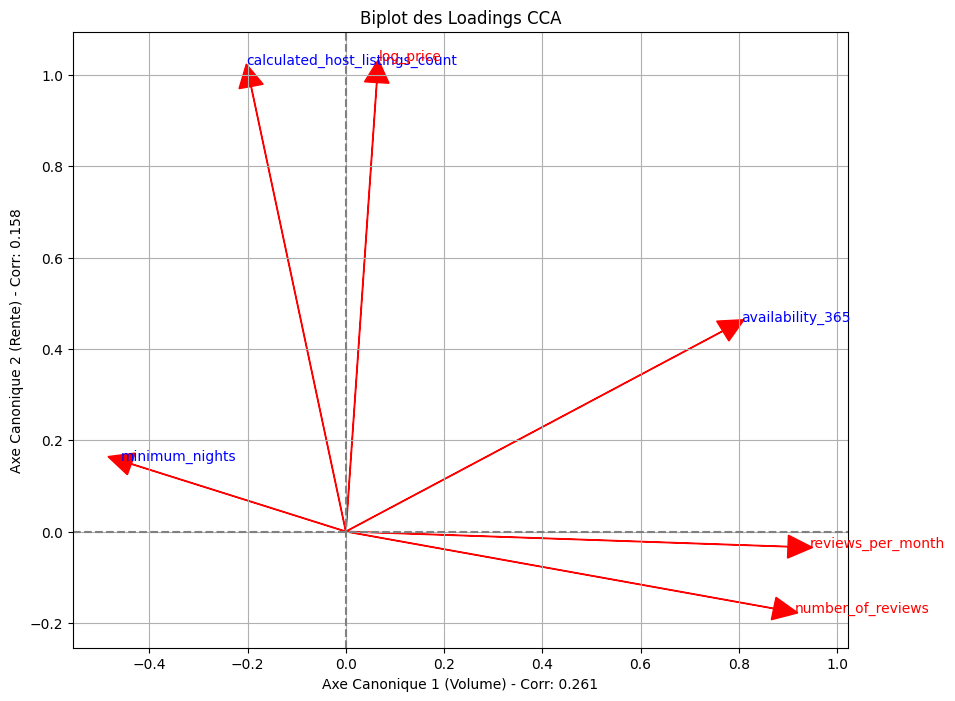

In [8]:
features_X = ['calculated_host_listings_count', 'availability_365', 'minimum_nights']
features_Y = ['log_price', 'number_of_reviews', 'reviews_per_month']
loadings_df = pd.concat([pd.DataFrame(x_loadings, index=features_X),
                         pd.DataFrame(y_loadings, index=features_Y)])
loadings_df.columns = ['CV1', 'CV2']

plt.figure(figsize=(10, 8))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

# Trace des vecteurs
for i in range(len(loadings_df)):
    x = loadings_df.iloc[i]['CV1']
    y = loadings_df.iloc[i]['CV2']
    plt.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, fc='r', ec='r')

    # Annotations : Colorez différemment les variables X et Y
    color = 'blue' if loadings_df.index[i] in features_X else 'red'
    plt.text(x * 1.05, y * 1.05, loadings_df.index[i], color=color)

plt.xlabel('Axe Canonique 1 (Volume) - Corr: 0.261')
plt.ylabel('Axe Canonique 2 (Rente) - Corr: 0.158')
plt.title('Biplot des Loadings CCA')
plt.grid(True)
plt.show()